In [1]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from scipy.ndimage import rotate

<class 'numpy.ndarray'>


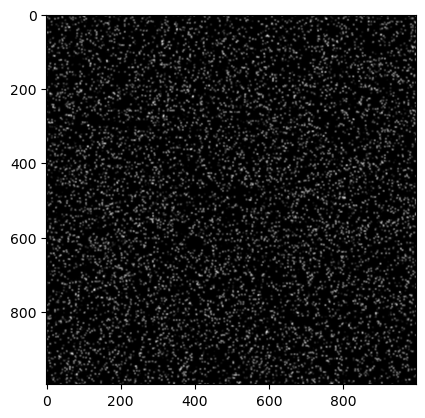

In [2]:
img = cv2.imread('gussian_conv.jpg',0)
print(type(img))
plt.imshow(img, cmap="gray")

(1403, 1403)


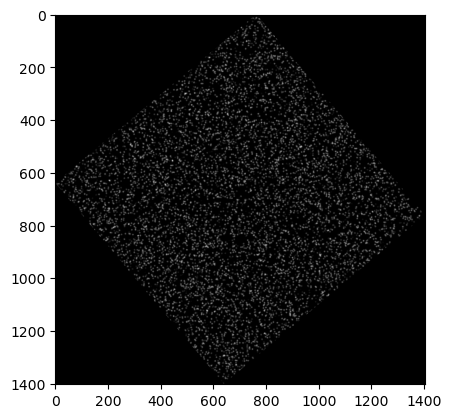

In [3]:
ag = 40
img_rot = rotate(img, angle=ag)
plt.imshow(img_rot, cmap="gray")
print(img_rot.shape[:2])

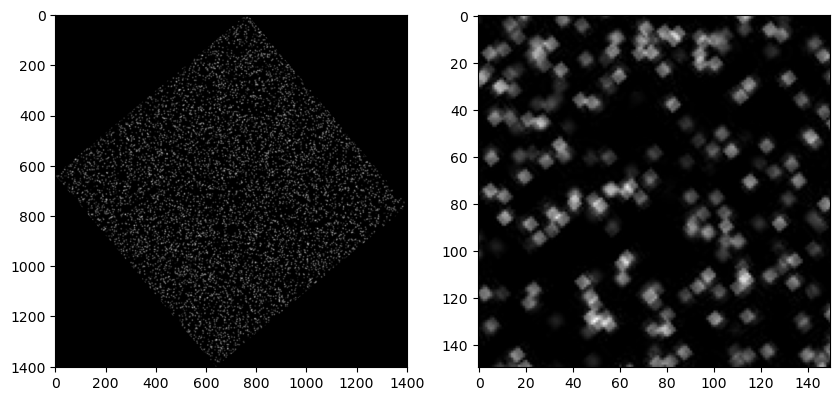

In [4]:
patch_size = (150,150)
# image_res = (2000, 2000)
patch_loc = (150,750)
color = (0, 255, 0)
thickness = 4

# img = img[0:1000, 0:1000]

cropped_image = img_rot[patch_loc[0]:patch_size[0]+patch_loc[0], patch_loc[1]:patch_size[1]+patch_loc[1]]
# img_rect = cv2.rectangle(img, patch_loc, (patch_size[0]+patch_loc[1],patch_size[1]+patch_loc[1]), color, thickness)

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(img_rot, cmap="gray")
ax[1].imshow(cropped_image, cmap="gray")

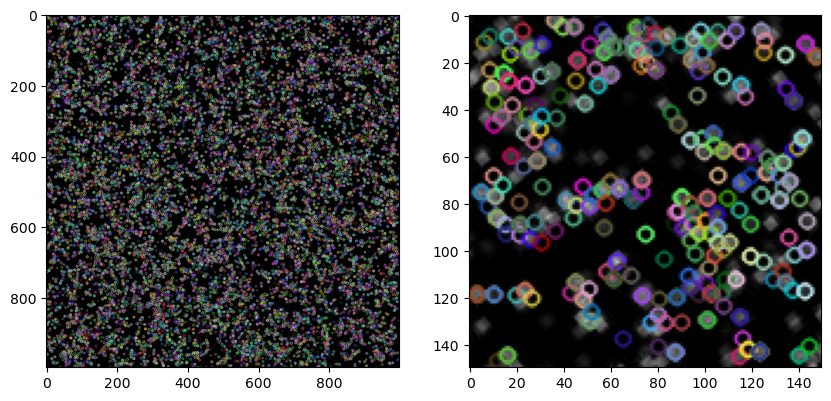

In [5]:
orb = cv2.ORB_create(nfeatures=50000)
detector = cv2.SIFT_create(nfeatures=40000)

kp1, des1 = detector.detectAndCompute(img, None)
kp2, des2 = detector.detectAndCompute(cropped_image, None)

imgkp1 = cv2.drawKeypoints(img, kp1, None)
imgkp2 = cv2.drawKeypoints(cropped_image, kp2, None)

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(imgkp1)
ax[1].imshow(imgkp2)

In [6]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [7]:
cropped_image.shape

(150, 150)

In [8]:
good = []
for m,n in matches:
    if m.distance < .1*n.distance:
        good.append(m)
        
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good     ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img_rot.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

# dst = cv2.perspectiveTransform(pts,M)
# dst += (w, 0)  # adding offset

In [9]:
good[0].trainIdx

19

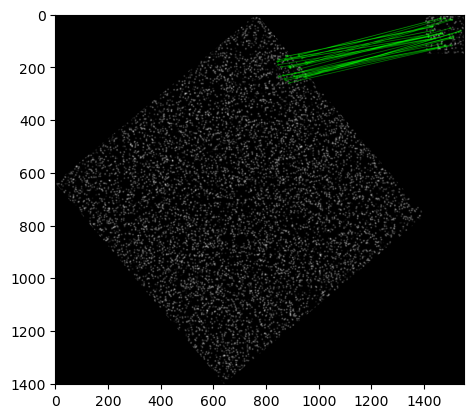

In [10]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)

img3 = cv2.drawMatches(img_rot,kp1,cropped_image,kp2, good, None, **draw_params)
plt.imshow(img3)

In [11]:
# matches = sorted(matches, key = lambda x:x.distance)

good_matches = matches[:10]

# src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# matchesMask = mask.ravel().tolist()
# h,w = cropped_image.shape[:2]
# pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

dst = cv2.perspectiveTransform(pts,M)
# dst += (w, 0)  # adding offset

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               alpha = 0.1,
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)

# img3 = cv2.polylines(img3, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)

predxy1 = tuple(np.int32(dst)[0][0])
predxy2 = (np.int32(dst)[0][0][0]+patch_size[0], np.int32(dst)[0][0][1]+patch_size[1])

img_rect = cv2.rectangle(img3, predxy1, predxy2, (255, 0, 0), 6)

print(dst)
print("coordinates: {}, {}".format(predxy1, predxy2))

[[[-744.68805  487.28876]]

 [[ 149.54657 1532.3151 ]]

 [[1216.1235   657.9757 ]]

 [[ 325.81802 -414.8188 ]]]
coordinates: (-744, 487), (-594, 637)


[[68 49 43 ...  0  0  0]
 [72 61 35 ...  3  3  3]
 [52 46 28 ...  6  8  6]
 ...
 [ 0  0  0 ... 38 37 39]
 [ 0  0  0 ... 73 67 61]
 [ 0  0  0 ... 85 81 71]]
Error 255


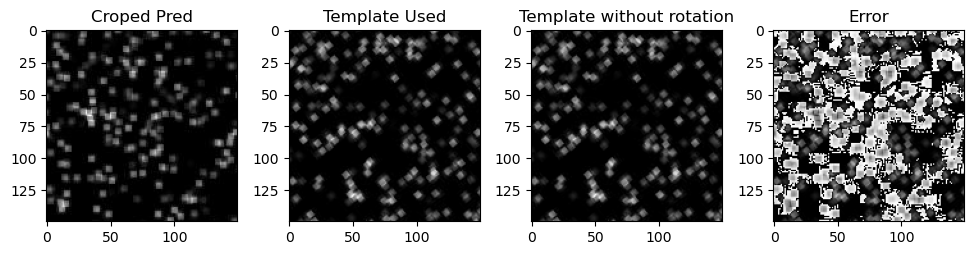

In [12]:
cropped_pred_image = img[predxy1[1]:predxy1[1]+patch_size[0], predxy1[0]:predxy1[0]+patch_size[1]]
print(cropped_pred_image)
fig, ax = plt.subplots(1,4, figsize=(10,5))
cropped_image_norot = rotate(cropped_image, angle=-ag)#[75:225, 75:225]
ax[0].imshow(cropped_pred_image, cmap="gray")
ax[0].set_title("Croped Pred")
ax[1].imshow(cropped_image, cmap="gray")
ax[1].set_title("Template Used")
ax[2].imshow(cropped_image, cmap="gray")
ax[2].set_title("Template without rotation")
plt.tight_layout()
# cropped_image = rotate(cropped_image, angle=ag)
error = (cropped_image-cropped_pred_image)
ax[3].imshow(error, cmap="gray")
ax[3].set_title("Error")
print("Error {}".format(error.max()))

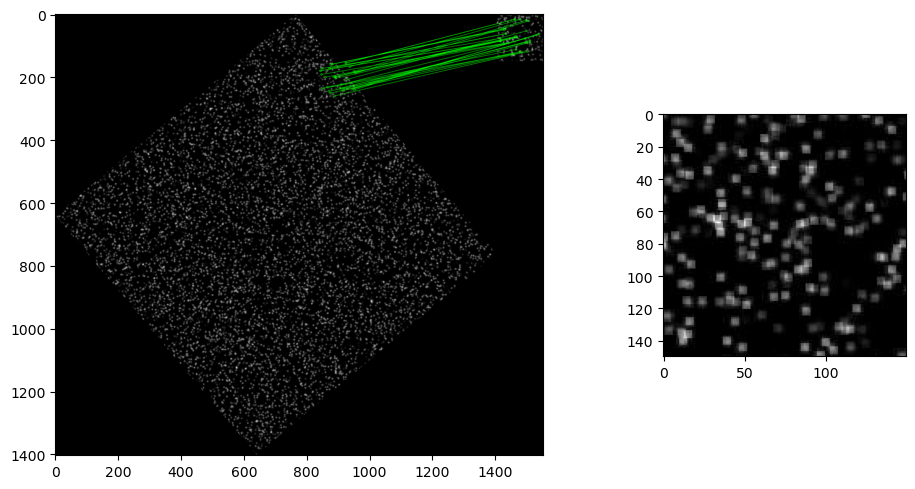

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [3, 1]})
ax[0].imshow(img_rect)
ax[1].imshow(cropped_pred_image, cmap="gray")
plt.tight_layout()
fig.savefig("matched.jpg")

In [14]:
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

Mean Sq Error:  32.89657777777778


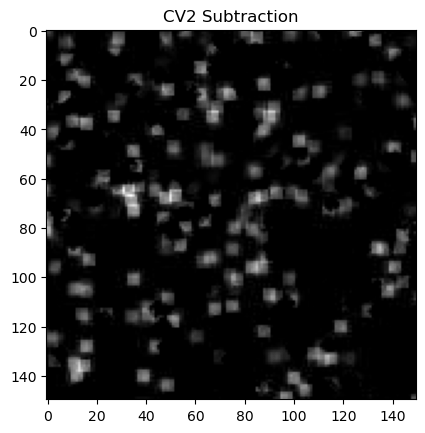

In [15]:
error, diff = mse(cropped_pred_image, cropped_image)
print("Mean Sq Error: ", error)
plt.title("CV2 Subtraction")
plt.imshow(diff, cmap="gray")

[[[ 900  150]]

 [[ 900  299]]

 [[1049  299]]

 [[1049  150]]]


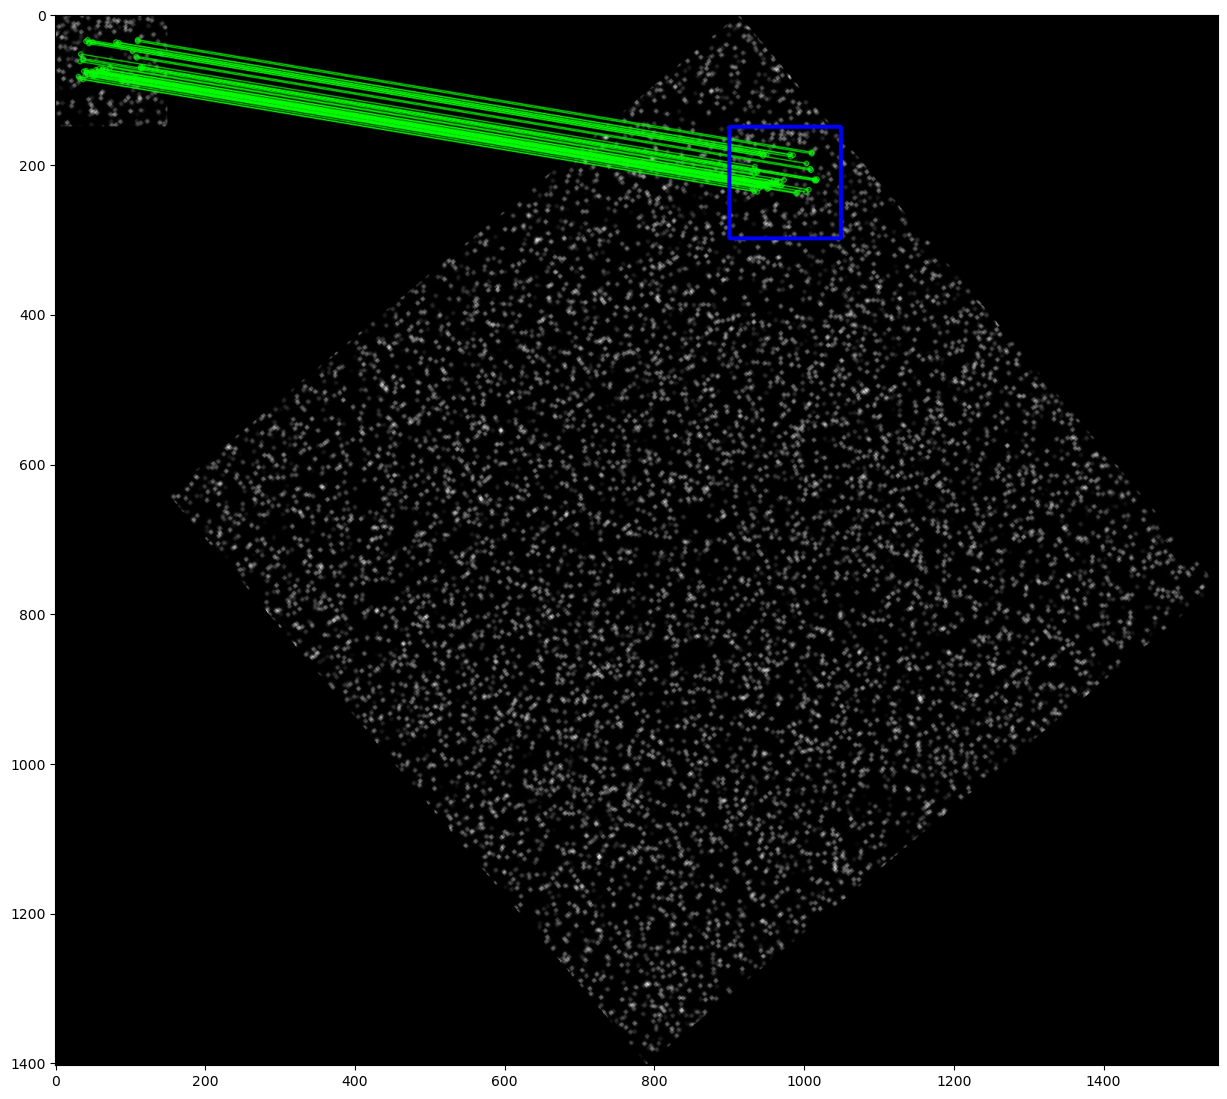

In [16]:
img1 = cropped_image         # query Image
img2 = img_rot  # target Image

# Initiate SIFT detector
orb = cv2.ORB_create(nfeatures=50000)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

good_matches = matches[:50]

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches     ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

dst = cv2.perspectiveTransform(pts,M)
dst += (w, 0)  # adding offset

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches, None,**draw_params)

# Draw bounding box in Red
img3 = cv2.polylines(img3, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)
print(np.int32(dst))

fig = plt.figure(figsize=(15,15))
plt.imshow(img3)

In [17]:
# img = img3
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
# dst = cv2.Canny(gray, 0, 150)
# blured = cv2.blur(dst, (5,5), 0)    
# MIN_CONTOUR_AREA=100
# img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# Contours,imgContours = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# for contour in Contours:
#     if cv2.contourArea(contour) > MIN_CONTOUR_AREA:
#         [X, Y, W, H] = cv2.boundingRect(contour)
#         box=cv2.rectangle(img, (X, Y), (X + W, Y + H), (0,0,255), 2)

# cropped_image = img[X:W, Y:H]
# print([X,Y,W,H])
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(img3)
# ax[1].imshow(cropped_image)